# Assignment 7: Novelty Search
In our last assignment, we explored the idea of measuring diversity.  This week we'll turn it up to eleven, and directly incentivize diversity by playing around with novelty search.  

While not quite a deceptive landscape, we'll see how novelty search interacts with a rugged fitness landscape by revisiting our prior work on NK-landscapes from Assignment 3.  

In [1]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance

import time

Our NK fitness landscape function from Assignment 3.  

In [2]:
class Landscape:
    """ N-K Fitness Landscape
    """

    
    def __init__(self, n=10, k=2):
        self.n = n # genome length
        self.k = k # number of other loci interacting with each gene
        self.gene_contribution_weight_matrix = np.random.rand(n,2**(k+1)) # for each gene, a lookup table for its fitness contribution, which depends on this gene's setting and also the setting of its interacting neighboring loci
        
    # find values of interacting loci
    def get_contributing_gene_values(self, genome, gene_num):     
        contributing_gene_values = ""
        for i in range(self.k+1): # for each interacing loci (including the location of this gene itself)
            contributing_gene_values += str(genome[(gene_num+i)%self.n]) # for simplicity we'll define the interacting genes as the ones immediately following the gene in question.  Get the values at each of these loci
        return contributing_gene_values # return the string containing the values of all loci which affect the fitness of this gene
    
    # find the value of a partiuclar genome
    def get_fitness(self, genome):
        gene_values = np.zeros(self.n) # the value of each gene in the genome
        for gene_num in range(len(genome)): # for each gene
            contributing_gene_values = self.get_contributing_gene_values(genome, gene_num) # get the values of the loci which affect it
            gene_values[gene_num] = self.gene_contribution_weight_matrix[gene_num,int(contributing_gene_values,2)] # use the values of the interacting loci (converted from a binary string to base-10 index) to find the lookup table entry for this combination of genome settings
        return np.mean(gene_values) # define the fitness of the full genome as the average of the contribution of its genes (and return it for use in the evolutionary algoirthm)

### Q1: Baseline implementation
Let's copy our usual `Individual` and `evolutionary_algorithm` setup from before.  For simplicity in future questions, let's simplify our algorithm as much as possible, working with bit-string (as per the NK fitness function), mutation only (just flipping one bit) and no crossover, and simple truncation selection rather than tournament selection.  Like last week, let's also record genotypic diverity over time.

In [3]:
class Individual:
    
    def __init__(self, fitness_function, bit_string_length):
        self.fitness_function = fitness_function
        self.genome = np.random.randint(2, size = bit_string_length)
        self.fitness = 0
        
    def eval_fitness(self):
        self.fitness = self.fitness_function(self.genome)

In [4]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,bit_string_length))
    diversity_over_time = np.zeros(total_generations)
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,bit_string_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
            if crossover:
                [crossover_point1, crossover_point2] = sorted(np.random.randint(0,bit_string_length,2)) # crossover points for 2-point crossover (sorted to make indexing easier in the next step)
                child1.genome[crossover_point1:crossover_point2+1] = parent2.genome[crossover_point1:crossover_point2+1] # take the point between the crossover points and swap in the genes from the other parent
                child2.genome[crossover_point1:crossover_point2+1] = parent1.genome[crossover_point1:crossover_point2+1]

            # mutation
            for this_child in [child1,child2]:
                elements_to_mutate = set()
                while len(elements_to_mutate)<num_elements_to_mutate:
                    elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
                for this_element_to_mutate in elements_to_mutate:
                    this_child.genome[this_element_to_mutate] = (this_child.genome[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location
            
            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        population = population[:num_parents] # perform truncation selection (keep just top mu individuals to become next set of parents)
        
        # record keeping
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        
        solutions_over_time[generation_num,:] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
        
    return fitness_over_time, solutions_over_time, diversity_over_time 

Initialize recordkeeping

In [5]:
experiment_results = {}
solutions_results = {}
diversity_results = {}

### Q1b: Baseline Results
Let's pull all the pieces together and run `20` repitions of `100` generations of a population with `20` parents and `20` children.  Let's use a NK-landscape with a bitstring length (`N`) of `15` and a highly rugged landscape of `K = 14`.  (My repitions take about 1.5 second each)

In [6]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20
crossover = False

n = bit_string_length
k = bit_string_length - 1

for run_name in ["fitness_only"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        landscape = Landscape(n=n, k=k)
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

fitness_only 0 1.5843682289123535 0.6700631545436494
fitness_only 1 1.7294938564300537 0.7180342683385563
fitness_only 2 1.747509479522705 0.725422960038818
fitness_only 3 1.6028845310211182 0.7121564712013957
fitness_only 4 1.6969656944274902 0.675897759307328
fitness_only 5 1.724489450454712 0.6873133727738885
fitness_only 6 1.616396188735962 0.7082651283421195
fitness_only 7 1.7054729461669922 0.6830213662021148
fitness_only 8 1.7039716243743896 0.7166178809076704
fitness_only 9 1.5808649063110352 0.7361934383838192
fitness_only 10 1.6879584789276123 0.745936617115449
fitness_only 11 1.727492332458496 0.7190478187699124
fitness_only 12 1.6058869361877441 0.6824006959373967
fitness_only 13 1.782038927078247 0.7293510357706994
fitness_only 14 1.7430055141448975 0.7344847564939153
fitness_only 15 1.753014326095581 0.7469785199745973
fitness_only 16 1.621901273727417 0.6763835665462674
fitness_only 17 1.7525136470794678 0.6842248971630713
fitness_only 18 1.775533676147461 0.669891079294

### Q1c: Plotting
Please plot both the fitness over time and diversity over time of this run.

In [7]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me", x_label = "change me", y_label="change me", y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    fig, ax = plt.subplots() # generate figure and axes

    if isinstance(name, str): name = [name]; input_data = [input_data]

    # for this_input_data, this_name in zip(input_data, name):
    for this_name in name:
        print("plotting",this_name)
        this_input_data = input_data[this_name]
        total_generations = this_input_data.shape[1]

        if plot_bootstrap:
            boostrap_ci_generation_found = np.zeros((2,total_generations))
            for this_gen in range(total_generations):
                if this_gen%10==0: print(this_gen)
                boostrap_ci_generation_found[:,this_gen] = bootstrap.ci(this_input_data[:,this_gen], np.mean, alpha=0.05)


        ax.plot(np.arange(total_generations), np.mean(this_input_data,axis=0), label = this_name) # plot the fitness over time
        if plot_bootstrap:
            ax.fill_between(np.arange(total_generations), boostrap_ci_generation_found[0,:], boostrap_ci_generation_found[1,:],alpha=0.3) # plot, and fill, the confidence interval for fitness over time
        ax.set_xlabel(x_label) # add axes labels
        ax.set_ylabel(y_label)
        if y_limit: ax.set_ylim(y_limit[0],y_limit[1])
        plt.legend(loc='best'); # add legend
        
def plot_mean_and_bootstrapped_ci_multiple(input_data = None, title = 'overall', name = "change this", x_label = "x", y_label = "y", save_name=""):
    """ 
     
    parameters:  
    input_data: (numpy array of numpy arrays of shape (max_k, num_repitions)) solution met
    name: numpy array of string names for legend 
    x_label: (string) x axis label 
    y_label: (string) y axis label 
     
    returns: 
    None 
    """ 
 
    generations = len(input_data[0])
 
    fig, ax = plt.subplots() 
    ax.set_xlabel(x_label) 
    ax.set_ylabel(y_label) 
    ax.set_title(title) 
    for i in range(len(input_data)): 
        CIs = [] 
        mean_values = [] 
        for j in range(generations): 
            mean_values.append(np.mean(input_data[i][j])) 
            CIs.append(bootstrap.ci(input_data[i][j], statfunction=np.mean)) 
        mean_values=np.array(mean_values) 
 
        print(CIs) 
        high = [] 
        low = [] 
        for j in range(len(CIs)): 
            low.append(CIs[j][0]) 
            high.append(CIs[j][1]) 
 
        low = np.array(low) 
        high = np.array(high) 

        y = range(0, generations) 
        ax.plot(y, mean_values, label=name[i]) 
        ax.fill_between(y, high, low, alpha=.2) 
        ax.legend()

plotting fitness_only
0
10
20
30
40
50
60
70
80
90
plotting fitness_only
0
10
20
30
40
50
60
70
80
90


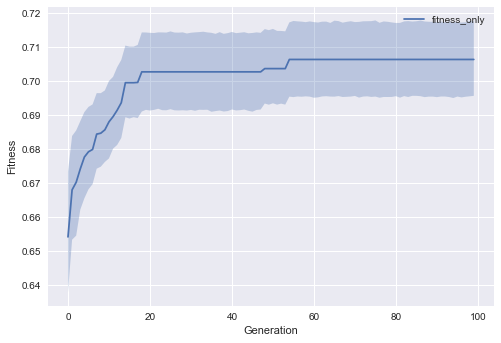

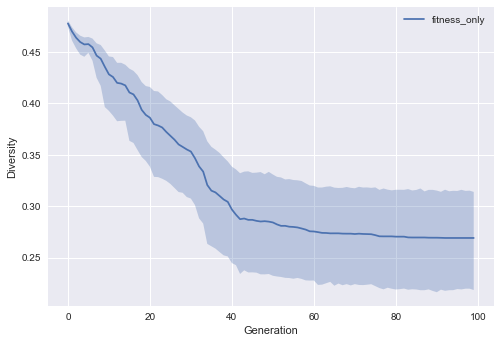

In [8]:
# plotting
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = ["fitness_only"], x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = ["fitness_only"], x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q2: Analysis
What do your results look like?  In what ways, if any, do you expect that they'll change if we search for novelty instead of fitness?  Why?

**The results look like fitness goes up over time and diversity goes down over time. I expect that this will change with novelty in that the diversity will bounce around but stay within a higher range than the final diversity here. I also expect for the fitness to climb more slowly but steadily over time as the discovery of better solutions are found.**

### Q3: Implementing Novelty
Let's implement novelty search! First, modify your `Individual` class to record `novelty` as an attribute (in additon to `fitness`).  

*Hint:* As ususal, you may want to skip ahead to the modification of your `evolutionary_algorithm` function in `Q4` and come back to fill in the helper functions in `Q3` once you have a better idea of when they'll be used (they just appear first to establish defniitions in case you `Restart and Run All`).

In [9]:
class Individual:
    
    def __init__(self, fitness_function, bit_string_length):
        self.fitness_function = fitness_function
        self.novelty_function = get_novelty
        self.genome = np.random.randint(2, size = bit_string_length)
        self.fitness = 0
        self.novelty = 0
        
    def eval_fitness(self):
        self.fitness = self.fitness_function(self.genome)
        
    def eval_novelty(self, archive, k):
        if self.novelty == 0:
            self.novelty = self.novelty_function(archive, self, k)

### Q3b: Caclulate Novelty
Let's define the novelty of a solution to be the average hamming/euclidean distance (i.e. number of differing bits) between the closest `k` genomes to it within an archive of prior solutions.  It may be helpful to define a helper function to calculate this quanity.  

In [10]:
# Function to find the cross over point (the point before which elements are
# smaller than or equal to x and after which greater than x)
def findCrossOver(arr, low, high, x) :
 
    # Base cases
    if (arr[high] <= x) : # x is greater than all
        return high
         
    if (arr[low] > x) : # x is smaller than all
        return low
     
    # Find the middle point
    mid = (low + high) // 2 # low + (high - low)// 2
     
    # If x is same as middle element, then return mid
    if (arr[mid] <= x and arr[mid + 1] > x) :
        return mid
     
    # If x is greater than arr[mid], then either arr[mid + 1] is ceiling of x
    # or ceiling lies in arr[mid+1...high]
    if(arr[mid] < x) :
        return findCrossOver(arr, mid + 1, high, x)
     
    return findCrossOver(arr, low, mid - 1, x)
 
# This function prints k closest elements to x in arr[]. n is the number of elements in arr[]
def getKclosest(solutions, x, k, n) :
    
    arr = [s.fitness for s in solutions]
    
#     arr = solutions
    
    neighbors = []
    
    # Find the crossover point
    l = findCrossOver(arr, 0, n - 1, x)
    r = l + 1 # Right index to search
    count = 0 # To keep track of count of elements already printed
 
    # If x is present in arr[], then reduce left index. Assumption: all elements
    # in arr[] are distinct
    if (arr[l] == x) :
        l -= 1
 
    # Compare elements on left and right of crossover point to find the k closest elements
    while (l >= 0 and r < n and count < k) :
         
        if (x - arr[l] < arr[r] - x) :
            neighbors.append(solutions[l])
#             print(arr[l], end = " ")
            l -= 1
        else :
            neighbors.append(solutions[r])
#             print(arr[r], end = " ")
            r += 1
        count += 1
 
    # If there are no more elements on right side, then print left elements
    while (count < k and l >= 0) :
        neighbors.append(solutions[l])
#         print(arr[l], end = " ")
        l -= 1
        count += 1
 
    # If there are no more elements on left side, then print right elements
    while (count < k and r < n) :
        neighbors.append(solutions[r])
#         print(arr[r], end = " ")
        r += 1
        count += 1
        
    return neighbors
        
def hamming_distance(s1, s2):
    """Calculate the Hamming distance between two bit strings"""
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))


def get_novelty(solution_archive, individual, k):

    # get the k closest neighbors from solution_archive according to fitness
    closest = getKclosest(solution_archive, individual.fitness, k, n=len(solution_archive))
#     hamming_distances = [hamming_distance(individual.genome, s.genome) for s in solution_archive]
#     closest = getKclosest(hamming_distances, 0, k+1, n=len(solution_archive))
    novelty = 0
    novelty = sum([hamming_distance(individual.genome, c.genome) for c in closest])
#     novelty = sum(closest)

    return novelty



### Q3c:  Selecting for Novelty
Please modify your evolutionary algorithm code to select (again, using the truncation selection as above) for the most novel solutions in our population (according to the novelty metric defined above), regardless of their fitness.  

In order to keep down the cost of computing the distance between a new genome and all those that have previously existed, let's also set a finite size to our novelty archive (as a parameter we can pass to the algorithm).  When we trying to add new genomes to the novelty archive, only add the the new individual if it has a higher novelty score than an individual already in the novelty archive (and remove that prior individual from the archive to keeep the archive size the same).  Let's also say that the novelty of an individual will be its novelty score when first being considered for additon to the archive (i.e. we do not have to re-calculate it in the future as the makeup of the archive changes).

It may also be helpful to build a helper function for (potentially) updating the archive with a new individual.

Feel free to use the indidivuals in the current generation for your archive calculation or not, whichever is more convenient for your implementation.  

*Hint:* If you've sorted the population by novelty for selection, don't forget that the population will no longer be in order of fitness when you go to record the fitness of most fit indidivual for record keeping!

In [11]:
def update_archive(solution_archive, individual, max_archive_length):
    if len(solution_archive) == max_archive_length:
        if individual.novelty < sorted(solution_archive, key=lambda i: i.novelty)[0].novelty:
            return solution_archive
        else:
            solution_archive = sorted(solution_archive, key=lambda i: i.novelty)
            solution_archive[0] = copy.deepcopy(individual)
    else:
        solution_archive.append(copy.deepcopy(individual))

    return solution_archive

In [12]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True, novelty_k = 0):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,bit_string_length))
    diversity_over_time = np.zeros(total_generations)
    solution_archive = []
    max_archive_length = 100
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,bit_string_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
        if len(solution_archive) < max_archive_length:
            solution_archive.append(population[i])
        else:
            population[i].eval_novelty(solution_archive, novelty_k)
            solution_archive = update_archive(solution_archive, population[i], max_archive_length)
        
        
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
            if crossover:
                [crossover_point1, crossover_point2] = sorted(np.random.randint(0,bit_string_length,2)) # crossover points for 2-point crossover (sorted to make indexing easier in the next step)
                child1.genome[crossover_point1:crossover_point2+1] = parent2.genome[crossover_point1:crossover_point2+1] # take the point between the crossover points and swap in the genes from the other parent
                child2.genome[crossover_point1:crossover_point2+1] = parent1.genome[crossover_point1:crossover_point2+1]

            # mutation
            for this_child in [child1,child2]:
                elements_to_mutate = set()
                while len(elements_to_mutate)<num_elements_to_mutate:
                    elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
                for this_element_to_mutate in elements_to_mutate:
                    this_child.genome[this_element_to_mutate] = (this_child.genome[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location
            
            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 
            if len(solution_archive) < max_archive_length:
                solution_archive.append(new_children[i])
            else:
                new_children[i].eval_novelty(solution_archive, novelty_k)
                solution_archive = update_archive(solution_archive, new_children[i], max_archive_length)

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        for i in range(len(population)):
            population[i].eval_novelty(solution_archive, novelty_k)
        population = sorted(population, key=lambda individual: individual.novelty, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        population = population[:num_parents] # perform truncation selection (keep just top mu individuals to become next set of parents)
        for i in range(len(population)):
            if len(solution_archive) < max_archive_length:
                solution_archive.append(population[i])
            else:
                solution_archive = update_archive(solution_archive, population[i], max_archive_length)
        
        # record keeping
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True)
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        
        solutions_over_time[generation_num,:] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
        
    return fitness_over_time, solutions_over_time, diversity_over_time 

### Q4: Run
Run novelty search with the same hyperparameter settings as above, and with a `novelty_k` value of `5` nearest neighbors for calculating the novelty metrics, from an archive of the `100` most novel individuals found thus far.  (My runs take about 3 seconds for each repitition)

In [13]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20
novelty_k = 5
crossover = False

n = bit_string_length
k = bit_string_length - 1

for run_name in ["novelty_k=5"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        landscape = Landscape(n=n, k=k)
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, novelty_k=novelty_k)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])


novelty_k=5 0 4.3457536697387695 0.7002817637336534
novelty_k=5 1 4.493380784988403 0.6469157352752016
novelty_k=5 2 4.421819448471069 0.6212326504451838
novelty_k=5 3 4.54392409324646 0.6212042257202249
novelty_k=5 4 4.404804706573486 0.6758338387270231
novelty_k=5 5 4.425823450088501 0.6618340881418373
novelty_k=5 6 4.5249083042144775 0.6302628315446329
novelty_k=5 7 4.374778747558594 0.6789913795811735
novelty_k=5 8 4.502889394760132 0.6884825967949598
novelty_k=5 9 4.361767530441284 0.6204395363191967
novelty_k=5 10 4.60597825050354 0.6613660737133944
novelty_k=5 11 4.386789083480835 0.6647120850166514
novelty_k=5 12 4.604477167129517 0.7274479781661463
novelty_k=5 13 4.4253222942352295 0.7070093989377695
novelty_k=5 14 4.6129841804504395 0.6505770546725429
novelty_k=5 15 4.370274782180786 0.6068271240976065
novelty_k=5 16 4.616487503051758 0.6437421547901813
novelty_k=5 17 4.482872247695923 0.6913272237660385
novelty_k=5 18 4.5589377880096436 0.7104980882149302
novelty_k=5 19 4.46

### Q4b: Plot
Please visualize the fitness and diversity over time for novelty search vs. fitness-based search

[array([0.6377392 , 0.67391834]), array([0.65282924, 0.68364408]), array([0.65495696, 0.68579633]), array([0.66240331, 0.68830029]), array([0.66572508, 0.69095345]), array([0.66788177, 0.69152931]), array([0.66926958, 0.69254894]), array([0.67434339, 0.69589481]), array([0.67464196, 0.6966715 ]), array([0.67576252, 0.69681353]), array([0.67716313, 0.70012078]), array([0.68013038, 0.70123612]), array([0.68134082, 0.70382541]), array([0.68319553, 0.70585514]), array([0.68920416, 0.71056439]), array([0.68888448, 0.71052548]), array([0.68913345, 0.71089757]), array([0.68886781, 0.71026647]), array([0.69187015, 0.71449377]), array([0.69160031, 0.71450085]), array([0.69151438, 0.71434814]), array([0.69132488, 0.71386977]), array([0.69142789, 0.71430081]), array([0.6912199 , 0.71421722]), array([0.69165134, 0.71435975]), array([0.69173059, 0.71449289]), array([0.691532  , 0.71407332]), array([0.69157616, 0.7142831 ]), array([0.69116706, 0.71396007]), array([0.69151524, 0.71418258]), array([0.

[array([0.47547316, 0.48322899]), array([0.44492044, 0.46682176]), array([0.39692502, 0.43828949]), array([0.33429456, 0.3899535 ]), array([0.29901998, 0.3529944 ]), array([0.27276837, 0.32943504]), array([0.26527019, 0.31882492]), array([0.25816248, 0.30971656]), array([0.25753673, 0.30825553]), array([0.25796547, 0.30803348]), array([0.2579752 , 0.30861843]), array([0.25823018, 0.30788015]), array([0.25799687, 0.30787456]), array([0.25791249, 0.30797422]), array([0.25806538, 0.30824454]), array([0.25806526, 0.30908147]), array([0.25804736, 0.3095281 ]), array([0.25746145, 0.30885624]), array([0.25795406, 0.30854419]), array([0.25819373, 0.30807167]), array([0.25806466, 0.3082078 ]), array([0.25781036, 0.30827461]), array([0.25784482, 0.30987592]), array([0.2581164, 0.3097988]), array([0.25818072, 0.30919224]), array([0.25861083, 0.30876182]), array([0.25823516, 0.30865319]), array([0.25866597, 0.30987151]), array([0.25756778, 0.30806623]), array([0.2585524 , 0.30820929]), array([0.25

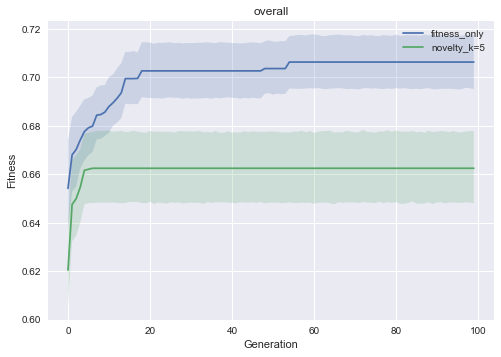

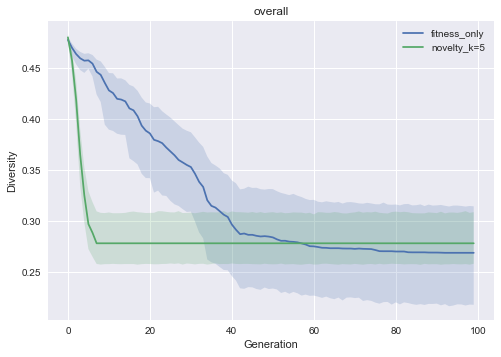

In [14]:
# plotting
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in experiment_results.items() if ("novelty_k=5" == k) or ('fitness_only' in k)], name=[k for k,x in experiment_results.items() if ("novelty_k=5" == k) or ('fitness_only' in k)], x_label="Generation", y_label="Fitness")
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in diversity_results.items() if ("novelty_k=5" == k) or ('fitness_only' in k)], name=[k for k,x in experiment_results.items() if ("novelty_k=5" == k) or ('fitness_only' in k)], x_label="Generation", y_label="Diversity")


### Q5: Analysis
How does novelty search perform in this domain?  Is it what you expected?  If no, why might that be the case?

**Novelty seems to perform very poorly. This is not what I was expecting, but upon thinking more deeply about this particular situation, it might start to make sense. We are calculating novelty as the hamming distance between the genomes in the archive with the closest fitness. This is a fitness-based (and, in this case, phenotypic) measurement of novelty, whereas our diversity calculation is completed genotypic. This still doesn't explain everything since we can see even our fitness values begin to converge fairly quickly. I believe this is because we only calculate novelty the first time an individual is assessed. We do actually maintain a higher level of diversity in the end than the fitness based evolution, but our fitness scores do not do as well as I imagined. I also wonder if this has something to do with the ruggedness of the landscape and the calculation of novelty only being the 5 nearest fitness values.**

### Q6: Larger Neighborhoods
How might you expect the result to change if you were to use a larger neighborhood (`novelty_k` value) for calculating a soluton's novelty.  

Let's try it!  Please run and plot the same settings as above, but with a `novelty_k` of `100` (i.e. using the full archive for novelty calcuation).

In [15]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20
novelty_k = 100
crossover=False

n = bit_string_length
k = bit_string_length-1

for run_name in ["novelty_k=100"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        landscape = Landscape(n=n, k=k)
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, novelty_k=novelty_k)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])


novelty_k=100 0 4.4798688888549805 0.6619972382123518
novelty_k=100 1 4.373277902603149 0.636580596515919
novelty_k=100 2 4.388790845870972 0.6867917179054371
novelty_k=100 3 4.560939311981201 0.686845927043569
novelty_k=100 4 4.359265089035034 0.6533997035658649
novelty_k=100 5 4.544925689697266 0.6662763292584775
novelty_k=100 6 4.454347372055054 0.668930726685939
novelty_k=100 7 4.546927213668823 0.6409351751460461
novelty_k=100 8 4.418816566467285 0.6426378413465449
novelty_k=100 9 4.557936906814575 0.6746594534195992
novelty_k=100 10 4.4338295459747314 0.6499868381943565
novelty_k=100 11 4.490378379821777 0.6617703671206865
novelty_k=100 12 4.460352897644043 0.6795110561402821
novelty_k=100 13 4.587462425231934 0.6414139039781336
novelty_k=100 14 4.398799419403076 0.6247527447029849
novelty_k=100 15 4.633001804351807 0.6029885433896425
novelty_k=100 16 4.42432165145874 0.757907598039554
novelty_k=100 17 4.618989706039429 0.6065104868740989
novelty_k=100 18 4.4003005027771 0.615725

[array([0.63742968, 0.6740432 ]), array([0.65299521, 0.68376136]), array([0.65492503, 0.68600854]), array([0.66217143, 0.68856043]), array([0.66569527, 0.69105584]), array([0.66809702, 0.69171371]), array([0.6694831 , 0.69260739]), array([0.67457356, 0.69627246]), array([0.67513691, 0.69660181]), array([0.6757525 , 0.69695926]), array([0.67732741, 0.70038496]), array([0.68013567, 0.70157308]), array([0.68081404, 0.70350971]), array([0.68289203, 0.70625186]), array([0.68899009, 0.71021516]), array([0.68893301, 0.71037203]), array([0.68862595, 0.71026713]), array([0.68918249, 0.7106933 ]), array([0.69132947, 0.71439202]), array([0.69151559, 0.71429776]), array([0.6914957, 0.7142263]), array([0.69137644, 0.71459408]), array([0.69144073, 0.7140422 ]), array([0.69123258, 0.71414342]), array([0.69127533, 0.71423778]), array([0.69133357, 0.71401024]), array([0.69150895, 0.71443494]), array([0.69143116, 0.71420649]), array([0.69121627, 0.71380393]), array([0.69145689, 0.71409557]), array([0.69

[array([0.47487337, 0.48088531]), array([0.4617969 , 0.47431714]), array([0.45318141, 0.469145  ]), array([0.44807834, 0.46616277]), array([0.44548658, 0.46405107]), array([0.44940873, 0.46456218]), array([0.44118047, 0.46319937]), array([0.42378929, 0.45852942]), array([0.41652837, 0.45710363]), array([0.39562325, 0.45139127]), array([0.39243384, 0.44576148]), array([0.39049436, 0.44505245]), array([0.38597163, 0.44005888]), array([0.38365022, 0.43982712]), array([0.38334809, 0.43788258]), array([0.36157429, 0.43347071]), array([0.35976632, 0.43218128]), array([0.35743737, 0.4274167 ]), array([0.3476462 , 0.42141718]), array([0.34349843, 0.41647067]), array([0.33993568, 0.41534452]), array([0.32920902, 0.41249136]), array([0.32740053, 0.41071696]), array([0.32768136, 0.40910494]), array([0.32464139, 0.40458851]), array([0.3192408 , 0.40194871]), array([0.3164438 , 0.39809246]), array([0.31476497, 0.39355771]), array([0.31147276, 0.39198025]), array([0.31052107, 0.38868314]), array([0.

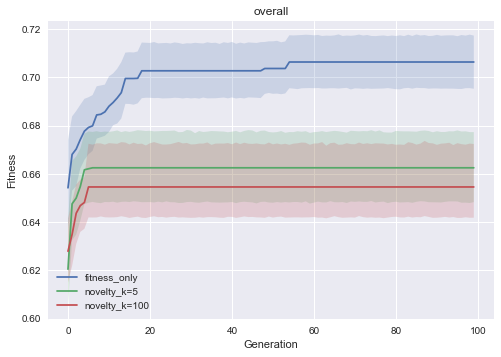

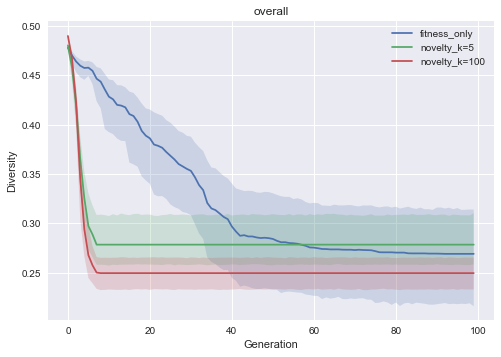

In [16]:
# plotting
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in experiment_results.items() if k in ["novelty_k=100", 'novelty_k=5', 'fitness_only']], name=[k for k,x in experiment_results.items() if k in ["novelty_k=100", 'novelty_k=5', 'fitness_only']], x_label="Generation", y_label="Fitness")
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in diversity_results.items() if k in ["novelty_k=100", 'novelty_k=5', 'fitness_only']], name=[k for k,x in experiment_results.items() if k in ["novelty_k=100", 'novelty_k=5', 'fitness_only']], x_label="Generation", y_label="Diversity")


### Q6b: Analysis
What happened?  Did it work better or worse?  Is this what you expected (and why)?

**It looks like we end up with less diversity and fitness in the end than when comparing against 5 neighbors. This is interesting as well. It doesn't seem to have changed much. It isn't what I expected. I would have expected higher numbers of diversity since we are taking novelty as the hamming distance between the individual's fitness and every other fitness in the solution archive instead of just 5. This could be due to the fact that we are measuring diversity and novelty very differently as stated above. The algorithm is going to try to find unique fitness values, but that won't necessary satisfy diversity.**

### Q7: Mixed Fitness and Novelty
As suggested in class, perhaps the best version of an evolutionary algorithm is not one that selects just for fitness or one that selects just for novelty, but one that considers both in an attempt to carefully tradeoff exploration and exploitation. 

We may not be the most careful and inentional with our tradeoffs here, but let's start with perhaps the simplest combination of selecting for both novelty and fitness one could think of.  Let's select some of the individuals in our population on the basis of novelty and some on the basis of fitness.  

In particular, pleae define a new parameter `novelty_selection_prop` that defines what proportion of the parents for the next generation will be selected by novelty (and choose the most novel solutions to occupy that portion of the new generation) while the remainder of the new population (`1-novelty_selection_prop`) gets selected on the basis of fitness -- resulting in the same `num_parents` as before heading into the next generation.  

In [17]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, bit_string_length=10, num_elements_to_mutate=1, crossover=True, novelty_k = 0, novelty_selection_prop = 0):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        bit_string_length: (int) length of bit string genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        crossover (bool): whether to perform crossover when generating children 
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,bit_string_length))
    diversity_over_time = np.zeros(total_generations)
    solution_archive = []
    max_archive_length = 100
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,bit_string_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
        if len(solution_archive) < max_archive_length:
            solution_archive.append(population[i])
        else:
            population[i].eval_novelty(solution_archive, novelty_k)
            solution_archive = update_archive(solution_archive, population[i], max_archive_length)
        
        
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
            if crossover:
                [crossover_point1, crossover_point2] = sorted(np.random.randint(0,bit_string_length,2)) # crossover points for 2-point crossover (sorted to make indexing easier in the next step)
                child1.genome[crossover_point1:crossover_point2+1] = parent2.genome[crossover_point1:crossover_point2+1] # take the point between the crossover points and swap in the genes from the other parent
                child2.genome[crossover_point1:crossover_point2+1] = parent1.genome[crossover_point1:crossover_point2+1]

            # mutation
            for this_child in [child1,child2]:
                elements_to_mutate = set()
                while len(elements_to_mutate)<num_elements_to_mutate:
                    elements_to_mutate.add(np.random.randint(bit_string_length)) # randomly select the location in the child bit string to mutate
                for this_element_to_mutate in elements_to_mutate:
                    this_child.genome[this_element_to_mutate] = (this_child.genome[this_element_to_mutate] + 1) % 2 # flip the bit at the chosen location
            
            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 
            if len(solution_archive) < max_archive_length:
                solution_archive.append(new_children[i])
            else:
                new_children[i].eval_novelty(solution_archive, novelty_k)
                solution_archive = update_archive(solution_archive, new_children[i], max_archive_length)

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        for i in range(len(population)):
            population[i].eval_novelty(solution_archive, novelty_k)
        new_population = sorted(population, key=lambda individual: individual.novelty, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        new_population = population[:num_parents*novelty_selection_prop] # perform truncation selection (keep just top mu individuals to become next set of parents)
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True) # sort the full population by each individual's fitness (from highers to lowest)
        population = population[:num_parents*(1-novelty_selection_prop)] # perform truncation selection (keep just top mu individuals to become next set of parents)
        population.extend(new_population)
        for i in range(len(population)):
            if len(solution_archive) < max_archive_length:
                solution_archive.append(population[i])
            else:
                solution_archive = update_archive(solution_archive, population[i], max_archive_length)
        
        # record keeping
        population = sorted(population, key=lambda individual: individual.fitness, reverse=True)
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        
        solutions_over_time[generation_num,:] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
        
    return fitness_over_time, solutions_over_time, diversity_over_time 

### Q8: Experimentation
Let's try running this mixed selection criteria for a 50/50 split between suvivors/parents for the next generation selected via novelty vs. fitness.  Let's do this with our original novelty neighbhorhood of size 5, and all other parameters the same.  

As usual, please plot fitness and diversity afterwards.

In [18]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20
crossover=False

novelty_k = 5
novelty_selection_prop = 0.5
max_archive_length = 100

n = bit_string_length
k = bit_string_length-1

for run_name in ["novelty_k=5,p=.5"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        landscape = Landscape(n=n, k=k)
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, novelty_k=novelty_k)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

novelty_k=5,p=.5 0 1.890132188796997 0.6995050106947066
novelty_k=5,p=.5 1 3.524043560028076 0.7310517062845779
novelty_k=5,p=.5 2 3.3874258995056152 0.7267657757110775
novelty_k=5,p=.5 3 1.846595048904419 0.7089544307444736
novelty_k=5,p=.5 4 2.188390016555786 0.7241594093941116
novelty_k=5,p=.5 5 3.7122063636779785 0.6828387306816893
novelty_k=5,p=.5 6 2.4676313400268555 0.6880514192887834
novelty_k=5,p=.5 7 1.954688549041748 0.7830663724826945
novelty_k=5,p=.5 8 2.6292710304260254 0.7118555086015538
novelty_k=5,p=.5 9 3.446977376937866 0.6937409390050512
novelty_k=5,p=.5 10 1.9526865482330322 0.6935523230300216
novelty_k=5,p=.5 11 2.5557074546813965 0.699289556280429
novelty_k=5,p=.5 12 1.941176414489746 0.7000571995707094
novelty_k=5,p=.5 13 3.3914294242858887 0.6982358282486344
novelty_k=5,p=.5 14 2.107820510864258 0.7229394484885391
novelty_k=5,p=.5 15 2.1383469104766846 0.7136498631482249
novelty_k=5,p=.5 16 1.9611940383911133 0.6919691581897226
novelty_k=5,p=.5 17 2.95755481719

[array([0.63800426, 0.67397723]), array([0.65302885, 0.68372443]), array([0.65508335, 0.68589875]), array([0.66240912, 0.68852299]), array([0.6660842 , 0.69111814]), array([0.66781274, 0.69181633]), array([0.66935456, 0.69231612]), array([0.6746909 , 0.69635494]), array([0.67455365, 0.69606818]), array([0.67578825, 0.69690078]), array([0.67739083, 0.70021097]), array([0.68010201, 0.70137469]), array([0.68110037, 0.70366298]), array([0.68310683, 0.70606705]), array([0.68914829, 0.71085256]), array([0.68912603, 0.7101579 ]), array([0.68898625, 0.71060629]), array([0.68926374, 0.71037813]), array([0.69131217, 0.71427396]), array([0.69113525, 0.71405954]), array([0.69107709, 0.71394941]), array([0.69165595, 0.714149  ]), array([0.69103722, 0.71410392]), array([0.69149274, 0.71432483]), array([0.69130216, 0.71417759]), array([0.69101441, 0.71418738]), array([0.69140837, 0.71438364]), array([0.69116547, 0.7136176 ]), array([0.69123306, 0.71382939]), array([0.69141494, 0.71451467]), array([0.

[array([0.47235486, 0.48156922]), array([0.46870718, 0.4775403 ]), array([0.46235791, 0.47446268]), array([0.4521627 , 0.46903754]), array([0.45123074, 0.46966732]), array([0.44411784, 0.46507327]), array([0.42997812, 0.46065336]), array([0.43014164, 0.45870635]), array([0.42523911, 0.45360598]), array([0.41848992, 0.45013696]), array([0.4173903 , 0.44928069]), array([0.41081038, 0.44495211]), array([0.41077672, 0.4457891 ]), array([0.4094887 , 0.44451352]), array([0.40157145, 0.43886371]), array([0.38759623, 0.43289369]), array([0.38026151, 0.42821317]), array([0.36109466, 0.42151515]), array([0.35979577, 0.4202274 ]), array([0.35194469, 0.41524297]), array([0.35217056, 0.41177081]), array([0.35223515, 0.41027805]), array([0.34747675, 0.40838061]), array([0.3476047 , 0.40804507]), array([0.3459198 , 0.40637411]), array([0.34215245, 0.40480291]), array([0.33599639, 0.40048149]), array([0.33036226, 0.39477701]), array([0.32013695, 0.38913225]), array([0.31745811, 0.38834766]), array([0.

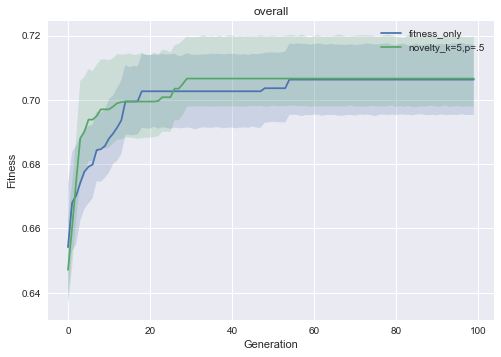

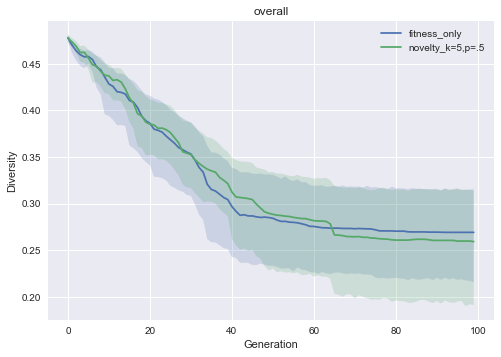

In [19]:
# plotting
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in experiment_results.items() if ("novelty_k=5,p=.5" in k) or ('fitness_only' in k)], name=[k for k,x in experiment_results.items() if ("novelty_k=5,p=.5" in k) or ('fitness_only' in k)], x_label="Generation", y_label="Fitness")
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in diversity_results.items() if ("novelty_k=5,p=.5" in k) or ('fitness_only' in k)], name=[k for k,x in experiment_results.items() if ("novelty_k=5,p=.5" in k) or ('fitness_only' in k)], x_label="Generation", y_label="Diversity")


### Q9: Analysis
What happened (to both fitness and diversity)?  Are you surprised?  Why would this be?

**This looks very similar to the fitness based evolutionary algorithm. There is slightly higher fitness and the standard deviation seems to be a bit wider in regards to diversity. I am a bit surprised that this doesn't differ more significantly from the fitness-based evolutionary algorithm. I think that maybe it is similar because it injects the selection pressure back into the algorithm which narrows the exploration of novelty search. It could also be a result of not testing novelty continuously and instead just using the initial novelty. All of these factors play a part in this outcome.**

### Q10:  Balancing Novelty and Fitness
Let's run this again with a different balance of novelty vs. fitness. Please run it with 90% of survivors selected via novelty and just 10% selected via fitness, and also vise versa with just 10% novelty and 90% fitness at each generation.  Which do you expect to work better?

**Judging from the previous charts, I think that the 90% fitness will work better than the 90% novelty since 100% novelty was not able to find very good solutions.**

### Q9b:  Running and Visualization
Let's findout!

In [20]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20
crossover=False

novelty_k = 5
novelty_selection_prop = 0
max_archive_length = 100

n = bit_string_length
k = bit_string_length-1

for run_name in ["novelty_k=5,p=.1", "novelty_k=5,p=.9"]:
    if run_name == "novelty_k=5,p=.1":
        novelty_selection_prop = 0.1
    else:
        novelty_selection_prop = 0.9
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        landscape = Landscape(n=n, k=k)
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, novelty_k=novelty_k)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

novelty_k=5,p=.1 0 2.1068193912506104 0.6945114137367722
novelty_k=5,p=.1 1 2.07879638671875 0.775179806422403
novelty_k=5,p=.1 2 1.8931350708007812 0.7148416850230094
novelty_k=5,p=.1 3 1.8210728168487549 0.7153837575965251
novelty_k=5,p=.1 4 2.359539747238159 0.6796332335668291
novelty_k=5,p=.1 5 1.8400890827178955 0.686632557636742
novelty_k=5,p=.1 6 3.948911666870117 0.6804958175325744
novelty_k=5,p=.1 7 3.286339282989502 0.7058112190602445
novelty_k=5,p=.1 8 2.0132389068603516 0.7050851081157946
novelty_k=5,p=.1 9 2.818434476852417 0.7039862336458136
novelty_k=5,p=.1 10 2.088804006576538 0.7175476509909788
novelty_k=5,p=.1 11 1.897639513015747 0.6891800369904755
novelty_k=5,p=.1 12 2.1893911361694336 0.699999079910343
novelty_k=5,p=.1 13 1.943178415298462 0.7275022872147943
novelty_k=5,p=.1 14 2.011737585067749 0.712489120238126
novelty_k=5,p=.1 15 2.5106685161590576 0.7074367359281942
novelty_k=5,p=.1 16 2.0242483615875244 0.6938856565810301
novelty_k=5,p=.1 17 1.8766210079193115

[array([0.63786504, 0.67405941]), array([0.6532683, 0.6838509]), array([0.65552689, 0.68581473]), array([0.66226739, 0.68858105]), array([0.66592399, 0.69100598]), array([0.66855934, 0.69238693]), array([0.66911393, 0.69246526]), array([0.67427599, 0.69627404]), array([0.67496283, 0.69665519]), array([0.67575451, 0.69726221]), array([0.67731192, 0.69995598]), array([0.68005025, 0.70096579]), array([0.68112076, 0.70345583]), array([0.68272525, 0.70597895]), array([0.68895126, 0.7102251 ]), array([0.68923978, 0.71060782]), array([0.68877584, 0.71025253]), array([0.68922355, 0.71047899]), array([0.69134927, 0.71401215]), array([0.69187021, 0.71439196]), array([0.69126535, 0.71411592]), array([0.69145139, 0.71416134]), array([0.69135901, 0.71410697]), array([0.69158166, 0.71411902]), array([0.69167687, 0.71436928]), array([0.69120861, 0.71412264]), array([0.69140125, 0.71400585]), array([0.69154065, 0.71407529]), array([0.69138799, 0.71405536]), array([0.69091604, 0.71390099]), array([0.69

[array([0.47479355, 0.48074938]), array([0.4618793 , 0.47428798]), array([0.45354577, 0.46916733]), array([0.44778776, 0.4660896 ]), array([0.44592224, 0.46417293]), array([0.44945561, 0.46481239]), array([0.44151854, 0.46296784]), array([0.42572513, 0.45871511]), array([0.41766973, 0.45706659]), array([0.39785893, 0.45160375]), array([0.39266338, 0.44584189]), array([0.3906243 , 0.44489241]), array([0.38471089, 0.44010197]), array([0.38426943, 0.43966607]), array([0.38400681, 0.43772928]), array([0.36092656, 0.43394125]), array([0.35699882, 0.43189394]), array([0.35637327, 0.42724766]), array([0.34730616, 0.42116452]), array([0.34476989, 0.41706361]), array([0.34079457, 0.41462304]), array([0.32860461, 0.41218755]), array([0.32809948, 0.41139722]), array([0.32714656, 0.40869603]), array([0.32403996, 0.40374637]), array([0.32051977, 0.40266044]), array([0.3176219 , 0.39835644]), array([0.31389943, 0.39384668]), array([0.31183605, 0.39139288]), array([0.31001062, 0.3885192 ]), array([0.

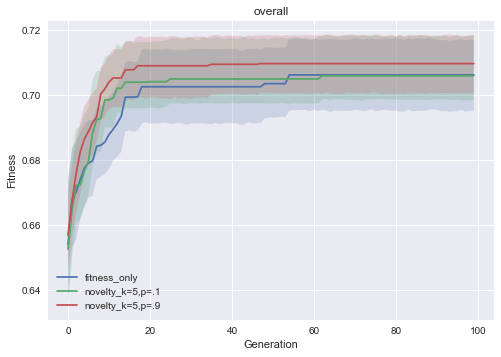

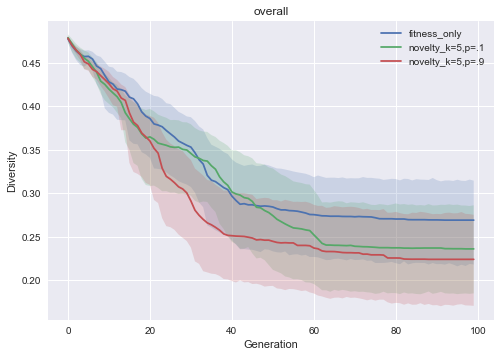

In [21]:
# plotting
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in experiment_results.items() if k in ['novelty_k=5,p=.1', 'novelty_k=5,p=.9', 'fitness_only']], name=[k for k,x in experiment_results.items() if k in ['novelty_k=5,p=.1', 'novelty_k=5,p=.9', 'fitness_only']], x_label="Generation", y_label="Fitness")
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in diversity_results.items() if k in ['novelty_k=5,p=.1', 'novelty_k=5,p=.9', 'fitness_only']], name=[k for k,x in diversity_results.items() if k in ['novelty_k=5,p=.1', 'novelty_k=5,p=.9', 'fitness_only']], x_label="Generation", y_label="Diversity")

### Q10: Analysis
Did the experiment turn out the way you thought it would?  Why or why not?  What does this imply about the use of novelty vs. fitness in expoitation vs. exploration?  Do the diveristy plots support this idea?

**It did not go as I thought it might. The 90% novelty (10% fitness), actually did quite well and better than any of the experiments so far. It had lower levels of diversity, but it had higher fitness than any of the previous cases. This implies that novelty can help exploit in certain situations. It might also need some some attention with regards to how novelty is injected to boost diversity in a population. It does okay at exploring the landscape and better at exploiting to do better than the rest of the cases in fitness. The diversity plots above are difficult to interpret, but I believe this may be one thing they portray.**

### Q11: The Effect of Ruggedness
How much do you think the conclusions you came to above are the result of the particular (maximally rugged) fitness landscape we experiemented with?  What would happen if we used a much smoother landscale (e.g. a NK landscape with `K=0`)

**I think it is very dependent on the landscape. If we used something more smooth, a selection process with more fitness bias might do better. I think that the novelty bias above does well because of the ruggedness of the landscape.**

### Q12: Experiementation
Let's find out!  Please pick your best ratio of novelty vs. fitness selection, and compare it to purely fitness and purely novelty selection on a NK landscale with `K=0`.  Please plot your results.

In [22]:
num_runs = 20
total_generations = 100
num_elements_to_mutate = 1
bit_string_length = 15
num_parents = 20
num_children = 20

novelty_k = 5
novelty_selection_prop = 0
max_archive_length = 100

n = bit_string_length
k = 0

for run_name in ["novelty_k=0", "novelty_k=0,p=.9", "fitness_k=0"]:
    if run_name == "novelty_k=0,p=.9":
        novelty_selection_prop = 0.9
    elif run_name == "novelty_k=0":
        novelty_selection_prop = 1
    else:
        novelty_selection_prop = 0
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, bit_string_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        landscape = Landscape(n=n, k=k)
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=landscape.get_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, bit_string_length=bit_string_length, num_elements_to_mutate=num_elements_to_mutate, crossover=crossover, novelty_k=novelty_k)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

novelty_k=0 0 0.307265043258667 0.7226598855742812
novelty_k=0 1 0.23270106315612793 0.6232785786905399
novelty_k=0 2 0.31277012825012207 0.6132617575964402
novelty_k=0 3 0.20017313957214355 0.669446471889682
novelty_k=0 4 0.20467686653137207 0.7017557270315685
novelty_k=0 5 0.1991720199584961 0.657482901519484
novelty_k=0 6 0.19466757774353027 0.6408114471614857
novelty_k=0 7 0.26372766494750977 0.7407483639507569
novelty_k=0 8 0.26372814178466797 0.6969967900443694
novelty_k=0 9 0.2682313919067383 0.7066916404344601
novelty_k=0 10 0.3092670440673828 0.5815655266414337
novelty_k=0 11 0.2532191276550293 0.7399312846194778
novelty_k=0 12 0.2261950969696045 0.6057963704694306
novelty_k=0 13 0.21968984603881836 0.6938081075258454
novelty_k=0 14 0.3117692470550537 0.6115423292102486
novelty_k=0 15 0.30876636505126953 0.5493551586059253
novelty_k=0 16 0.2877485752105713 0.7214114898474361
novelty_k=0 17 0.30776548385620117 0.7699956855671544
novelty_k=0 18 0.21168279647827148 0.642524540295

[array([0.63782975, 0.6738947 ]), array([0.65285318, 0.68359681]), array([0.65514393, 0.68584905]), array([0.66226606, 0.68852986]), array([0.66571016, 0.69096825]), array([0.66796669, 0.69193232]), array([0.66894709, 0.69224606]), array([0.67440422, 0.69602974]), array([0.67507375, 0.69681935]), array([0.67588232, 0.69716916]), array([0.67746045, 0.70032337]), array([0.68012929, 0.70100822]), array([0.68103913, 0.70380722]), array([0.68320983, 0.70594352]), array([0.68884447, 0.71044474]), array([0.68917116, 0.71045808]), array([0.68896975, 0.71034678]), array([0.6893287 , 0.71032476]), array([0.69149761, 0.71448747]), array([0.6910168 , 0.71395956]), array([0.69157175, 0.71424193]), array([0.69157387, 0.71411638]), array([0.69139766, 0.7144014 ]), array([0.69146088, 0.71410388]), array([0.69097661, 0.71394774]), array([0.69118187, 0.71430234]), array([0.69144891, 0.71469185]), array([0.69133398, 0.71440555]), array([0.69159823, 0.71425792]), array([0.69141161, 0.71396089]), array([0.

[array([0.56140715, 0.60975052]), array([0.56881483, 0.62094915]), array([0.5774264 , 0.63174001]), array([0.58584121, 0.63569451]), array([0.59372939, 0.64695168]), array([0.59936755, 0.65263193]), array([0.60492581, 0.65796938]), array([0.60907732, 0.66160807]), array([0.60986549, 0.66397634]), array([0.61406697, 0.66765704]), array([0.6170605 , 0.66911056]), array([0.61789972, 0.67046033]), array([0.61958032, 0.67078899]), array([0.62087795, 0.67279621]), array([0.62231795, 0.67333501]), array([0.62120001, 0.67365291]), array([0.62155028, 0.67400485]), array([0.62262505, 0.6745609 ]), array([0.62268222, 0.67485262]), array([0.62196745, 0.67392756]), array([0.62270002, 0.67510345]), array([0.62201193, 0.67385206]), array([0.62230695, 0.67469361]), array([0.62257172, 0.6748764 ]), array([0.62241562, 0.67427455]), array([0.62200297, 0.67475028]), array([0.62260022, 0.674814  ]), array([0.62260307, 0.6736008 ]), array([0.62186886, 0.67429788]), array([0.62200149, 0.67414205]), array([0.

[array([0.45710432, 0.46933652]), array([0.40850443, 0.4359832 ]), array([0.37833574, 0.41080882]), array([0.34392601, 0.37954616]), array([0.31080661, 0.35933851]), array([0.2800885 , 0.33084235]), array([0.26175652, 0.30890005]), array([0.23584424, 0.28435284]), array([0.21484597, 0.25730834]), array([0.19675763, 0.23140962]), array([0.1803452 , 0.21872255]), array([0.16906468, 0.20529621]), array([0.15656477, 0.1964861 ]), array([0.14324125, 0.18408433]), array([0.13595352, 0.17911583]), array([0.12684171, 0.16259019]), array([0.12132249, 0.15477382]), array([0.11257825, 0.14300342]), array([0.10507515, 0.13037532]), array([0.09781727, 0.12000972]), array([0.09139628, 0.11616233]), array([0.08440268, 0.10714917]), array([0.07201783, 0.09603826]), array([0.06356512, 0.08528567]), array([0.05947728, 0.08116553]), array([0.05609482, 0.07661516]), array([0.05186535, 0.07112153]), array([0.04642119, 0.06424157]), array([0.04152128, 0.05725723]), array([0.0363122 , 0.05095465]), array([0.

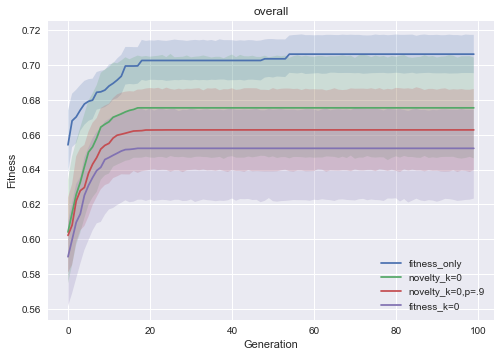

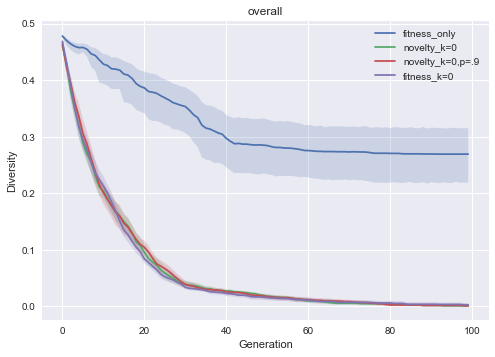

In [23]:
# plotting
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in experiment_results.items() if k in ["novelty_k=0", "novelty_k=0,p=.9", "fitness_k=0", "fitness_only"]], name=[k for k,x in experiment_results.items() if k in ["novelty_k=0", "novelty_k=0,p=.9", "fitness_k=0", "fitness_only"]], x_label="Generation", y_label="Fitness")
plot_mean_and_bootstrapped_ci_multiple(input_data=[np.transpose(x) for k, x in diversity_results.items() if k in ["novelty_k=0", "novelty_k=0,p=.9", "fitness_k=0", "fitness_only"]], name=[k for k,x in diversity_results.items() if k in ["novelty_k=0", "novelty_k=0,p=.9", "fitness_k=0", "fitness_only"]], x_label="Generation", y_label="Diversity")


### Q12b:  Analysis
Were you right?  Was novelty, or novelty+fitness helpful?  Was it harmful?  What was the effect on diversity?

**The fitness-based approach does seem to work best here with regards to overall fitness in the 100th generation. All of the charts for fitness and diversity look very similar with diversity almost 0 by the 80th generations and fitness  trending the same but reaching different values across all of the cases. It seems that injecting novelty in this situation is slightly harmful (at least in the manner that we are doing so). This is what I predicted above with an easier landscape, fitness-based solutions do better.**

### Q13: Future Work
In this assignment we explored just one (very simple) way to combine novelty and fitness, how else might you want to do this that could be more effetive (and why)?

**We could maintain novel subpopulations that compete based on fitness within their own groups. This could help by maintaining several highly fit, yet very diverse subpopulations of solutions.**

### Congratulations, you made it to the end!
Nice work -- and hopefully you're starting to get the hang of these!

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**Just me**